# Error rate arround repeats/G4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

basedir = Path("../analysis/stratification_error_rate")

## Region lengths

In [2]:
bed = []
for file in (basedir / "regions").rglob("*.bed"):
    d = pd.read_csv(file, sep="\t", usecols=[0,1,2])
    d.columns = ["chr", "start", "end"]
    d["region"] = file.stem.split("_")[0]
    bed.append(d)

bed = pd.concat(bed).reset_index(drop=True)
bed["len"] = bed["end"] - bed["start"]
lens = bed.groupby("region")["len"].agg(["median", "mean", "max"])
lens

,median,mean,max
region,,,
diTR10to49,12.0,17.318168,50
g4,30.0,30.807319,50
homopolymer7to11,7.0,8.446605,48
homopolymer7to11GC,7.0,7.620221,33
homopolymerge12,16.0,17.239176,50
homopolymerge12GC,13.0,13.421687,23
imperfecthomopolge11,14.0,16.591939,50
imperfecthomopolge11GC,12.0,13.393904,46
quadTR19to49,23.0,25.145530,50


<Axes: xlabel='len', ylabel='region'>

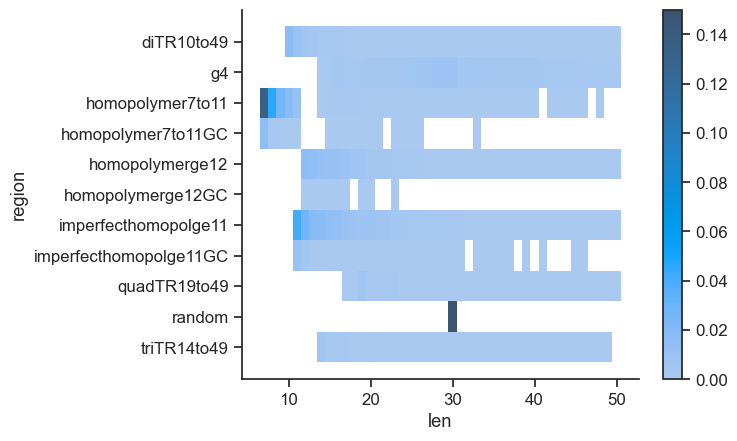

In [3]:
from matplotlib.colors import Normalize

sns.histplot(
    bed.sort_values("region"),
    x="len",
    y="region",
    stat="density",
    discrete=True,
    cbar=True,
)

## Load pileup quals

In [4]:
data = []
maxq = 0
for file in (basedir / "quals").rglob("*.tsv"):
    print(file)
    df = pd.read_csv(file, sep="\t")

    maxq = max(max(df.columns[3:].values.astype(int)), maxq)
    
    region, readdirection, mtype = file.stem.split("_")

    cell = file.parent.stem
    run = file.parent.parent.stem

    df["region"] = region
    df["run"] = run
    df["Cell line"] = cell
    df["mtype"] = mtype
    df["rfwd"] = readdirection == "forward"
    if region != "g4":
        df["ss"] = True
    data.append(df)

data = pd.concat(data)
data["Data source"] = data["run"].replace(run_names)
quals = [str(i) for i in range(1, maxq+1)]
quals_int = np.arange(1, maxq+1)
data = data.groupby(["Data source", "Cell line", "pos", "region", "mtype", "ss"])[quals + ["bases"]].sum().reset_index()

data["Bases"] = data[quals].sum(axis=1)
data["Bases"] = data["Bases"].astype(int)

# Bin the quality scores to match Illumina
# https://knowledge.illumina.com/instrumentation/novaseq-x-x-plus/instrumentation-novaseq-x-x-plus-reference_material-list/000008320
binnedQ = {
    0: (min(quals_int),2),
    12: (3, 17),
    24: (18, 29),
    40: (30, maxq),
}
binnedQ_keys = list(binnedQ.keys())
binnedQ_labels = [f"bin_{q}" for q in binnedQ_keys]
binnedQ_probs = [10 ** (-q / 10) for q in binnedQ_keys]

for q, (low, high) in binnedQ.items():
    qcols = [str(i) for i in range(low, high+1)]
    data["bin_" + str(q)] = data[quals].loc[:, qcols].sum(axis=1)

data["PctgtQ30"] = 100 * data["bin_40"] / data["Bases"]
data


../analysis/stratification_error_rate/quals/aviti_hq/REH/random_reverse_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/diTR10to49_forward_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/homopolymer7to11GC_reverse_middle.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/triTR14to49_reverse_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/homopolymerge12GC_forward_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/homopolymer7to11_reverse_middle.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/homopolymer7to11_forward_restrict.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/imperfecthomopolge11GC_forward_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/triTR14to49_forward_restrict.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/quadTR19to49_reverse_squach.tsv
../analysis/stratification_error_rate/quals/aviti_hq/REH/homopolymerge12_reverse_restri

,Data source,Cell line,pos,region,mtype,ss,1,2,3,4,...,43,44,45,bases,Bases,bin_0,bin_12,bin_24,bin_40,PctgtQ30
0,AVITI CB,KMS12BM,-162,diTR10to49,middle,True,0,0,0,0,...,1.0,2.0,0.0,6,6,0,0,0,6.0,100.0
1,AVITI CB,KMS12BM,-161,diTR10to49,middle,True,0,0,0,0,...,0.0,4.0,0.0,6,6,0,0,0,6.0,100.0
2,AVITI CB,KMS12BM,-161,random,middle,True,0,0,0,0,...,0.0,0.0,0.0,1,1,0,0,0,1.0,100.0
3,AVITI CB,KMS12BM,-160,diTR10to49,middle,True,0,0,0,0,...,0.0,4.0,0.0,6,6,0,0,0,6.0,100.0
4,AVITI CB,KMS12BM,-160,random,middle,True,0,0,0,0,...,0.0,0.0,0.0,1,1,0,0,0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130830,NovaSeqX+,REH,159,imperfecthomopolge11,middle,True,0,0,0,0,...,0.0,0.0,0.0,6,6,0,2,1,3.0,50.0
130831,NovaSeqX+,REH,160,diTR10to49,middle,True,0,0,0,0,...,0.0,0.0,0.0,3,3,0,0,0,3.0,100.0
130832,NovaSeqX+,REH,160,imperfecthomopolge11,middle,True,0,0,0,0,...,0.0,0.0,0.0,1,1,0,1,0,0.0,0.0
130833,NovaSeqX+,REH,161,diTR10to49,middle,True,0,0,0,0,...,0.0,0.0,0.0,2,2,0,0,0,2.0,100.0


## Plot quals

### Middle G4

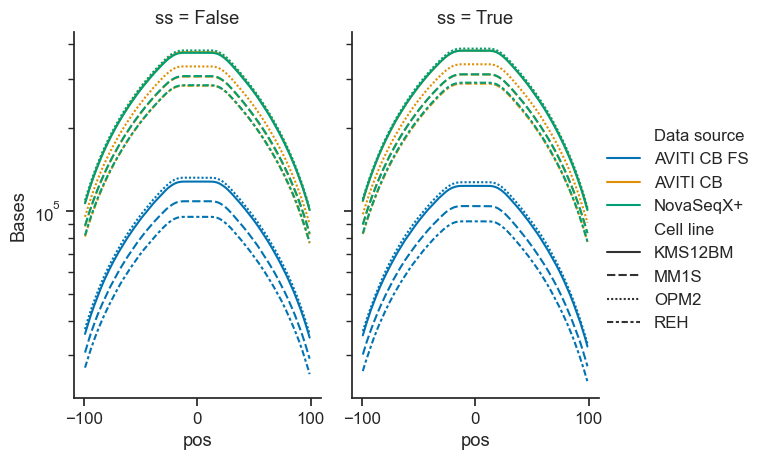

In [5]:
d = data.query("abs(pos) < 100 & mtype == 'middle' & region == 'g4'").copy()
g = sns.relplot(
    x="pos",
    y="Bases",
    hue="Data source",
    hue_order=run_names.values(),
    col="ss",
    data=d,
    height=4.8,
    aspect=0.7,
    kind="line",
    style="Cell line",
    facet_kws={"sharey": True},
)
g.set(yscale="log")

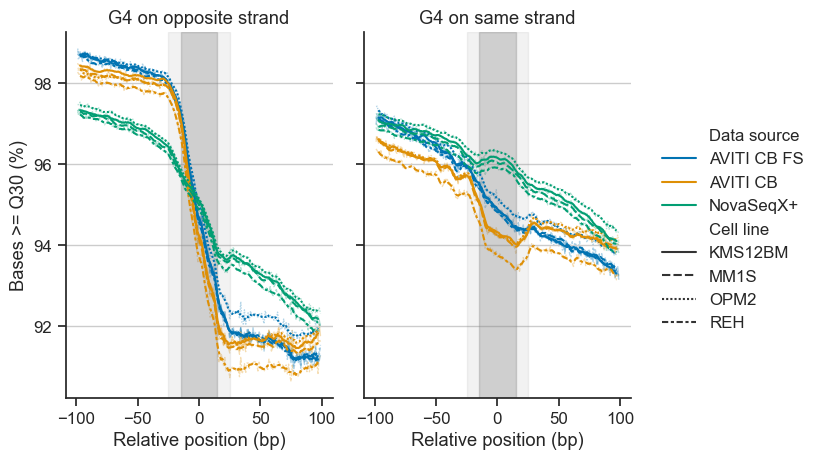

In [6]:
d = data.query("abs(pos) < 100 & mtype == 'middle' & region == 'g4'").copy()
d["PctgtQ30_smooth"] = d.groupby(["Data source", "ss", "Cell line"])["PctgtQ30"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

d["Strand"] = d["ss"].replace({False: "opposite", True: "same"})
g = sns.relplot(
    x="pos",
    y="PctgtQ30_smooth",
    hue="Data source",
    hue_order=run_names.values(),
    col="Strand",
    data=d,
    height=4.8,
    aspect=0.7,
    kind="line",
    style="Cell line",
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="PctgtQ30",
    hue="Data source",
    hue_order=run_names.values(),
    lw=1,
    alpha=0.3,
    style="Cell line",
    zorder=-1,
)


# add grid
for s, ax in g.axes_dict.items():
    ax.grid(True, axis="y")
    #ax.axvspan(-5, 5, color="gray", alpha=0.3)
    medl = lens.loc["g4", "median"]
    maxl = lens.loc["g4", "max"]
    ax.axvspan(0 - medl / 2, 0 + medl / 2, color="gray", alpha=0.3)
    ax.axvspan(0 - maxl / 2, 0 + maxl / 2, color="grey", alpha=0.1)

g.set(
    xlabel="Relative position (bp)",
    ylabel="Bases >= Q30 (%)",
    #ylim=(89, 100),
)
g.set_titles("G4 on {col_name} strand")

g.savefig(figdir / "g4_quality_by_strand.svg", bbox_inches="tight")

## Load base mismatch data

In [7]:
datab = []

for file in (basedir / "bases").rglob("*.tsv"):
    df = pd.read_csv(file, sep="\t")

    region, readdirection, mtype = file.stem.split("_")
    #if region == "g4":
    #    continue
    cell = file.parent.stem
    run = file.parent.parent.stem

    df["file"] = file.stem
    df["region"] = region
    df["run"] = run
    df["Cell line"] = cell
    df["mtype"] = mtype
    df["rfwd"] = readdirection == "forward"

    # Swap bases if read reversed
    if readdirection == "reverse":
       df[["A", "T"]] = df[["T", "A"]]
       df[["C", "G"]] = df[["G", "C"]]
    
    if region != "g4":
        df["ss"] = True
    datab.append(df)

datab = pd.concat(datab)
datab["Data source"] = datab["run"].replace(run_names)
datab = datab.query("bases > 100")
datab

,pos,ss,bases,A,C,G,T,+,-,file,region,run,Cell line,mtype,rfwd,Data source
32,-118,True,113,0,0,0,2,0,0,random_reverse_squach,random,aviti_hq,REH,squach,False,AVITI CB
33,-117,True,151,0,0,0,1,0,0,random_reverse_squach,random,aviti_hq,REH,squach,False,AVITI CB
34,-116,True,231,0,0,0,0,0,0,random_reverse_squach,random,aviti_hq,REH,squach,False,AVITI CB
35,-115,True,2991,0,3,2,2,0,0,random_reverse_squach,random,aviti_hq,REH,squach,False,AVITI CB
36,-114,True,5784,1,5,6,4,0,0,random_reverse_squach,random,aviti_hq,REH,squach,False,AVITI CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,125,True,760,2,3,0,1,0,0,g4_forward_squach,g4,xplus_sns,KMS12BM,squach,True,NovaSeqX+
575,126,True,562,0,2,0,0,0,0,g4_forward_squach,g4,xplus_sns,KMS12BM,squach,True,NovaSeqX+
576,127,True,407,2,2,1,2,0,0,g4_forward_squach,g4,xplus_sns,KMS12BM,squach,True,NovaSeqX+
577,128,True,255,1,0,0,0,0,0,g4_forward_squach,g4,xplus_sns,KMS12BM,squach,True,NovaSeqX+


## Plot bases G4

### Middle G4 -indels

('opposite', 'AVITI CB FS')
('opposite', 'AVITI CB')
('opposite', 'NovaSeqX+')
('same', 'AVITI CB FS')
('same', 'AVITI CB')
('same', 'NovaSeqX+')


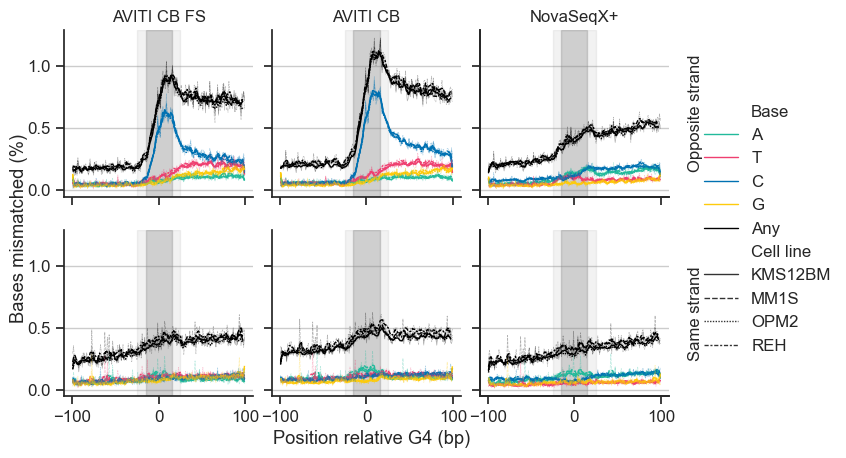

In [9]:
d = datab.query("abs(pos) < 100 & region == 'g4' & mtype == 'middle'").copy()

bases = list("ATCG")

d = d.groupby(["Data source", "Cell line", "pos", "ss"])[bases + ["bases"]].sum().reset_index()
d["Any"] = d[bases].sum(axis=1)
bases += ["Any"]
d[bases] = d[bases].div(d["bases"], axis=0) * 100
d["Strand"] = d["ss"].replace({False: "opposite", True: "same"})
d = d.melt(
    id_vars=["Data source", "Cell line", "pos", "Strand"],
    value_vars=bases,
    var_name="Base",
    value_name="Percentage",
)

d["Percentage_smooth"] = d.groupby(["Data source", "Cell line", "Strand"])["Percentage"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

# https://github.com/igvteam/igv/issues/862
palette = [
    (34,186,155), # A
    (239,63,112),   # T
    (0,113,178),    # C
    (254,203,12),    # G
    # (128, 0, 128),   # purple
    # (255, 0, 255),  # pink
    (0, 0, 0)    # total color is black
]
palette = [tuple(i / 255 for i in color) for color in palette]
g = sns.relplot(
    x="pos",
    y="Percentage_smooth",
    hue="Base",
    style="Cell line",
    col="Data source",
    col_order=run_names.values(),
    row="Strand",
    palette=palette,
    data=d,
    height=4.8/2,
    lw=1,
    aspect=1,
    kind="line",
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="Percentage",
    palette=palette,
    alpha=0.3,
    hue="Base",
    lw=0.5,
    style="Cell line",
)
g.set(
    xlabel="",
    ylabel="",
)
g.set_titles("")
g4_median_len = lens.loc["g4", "median"]
g4_max_len = lens.loc["g4", "max"]

for s, ax in g.axes_dict.items():
    print(s)
    ax.grid(True, axis="y")
    
    ax.axvspan(0 - g4_median_len / 2, 0 + g4_median_len / 2, color="gray", alpha=0.3)
    ax.axvspan(0 - g4_max_len / 2, 0 + g4_max_len / 2, color="grey", alpha=0.1)
        
    if ax.get_subplotspec().is_first_row():
        ax.set_title(s[1], fontsize=12)

    if ax.get_subplotspec().is_last_col():
        # Get secondary y-axis
        ax2 = ax.twinx()
        # Remove ticks and tick labels
        ax2.tick_params(axis="y", which="both", left=False, right=False)
        ax2.set_yticklabels([])
        ax2.set_ylabel(s[0].capitalize() + " strand", fontsize=12)

g.fig.subplots_adjust(wspace=0.1, hspace=0.2)

# Add common ylabel
g.fig.text(0.03, 0.5, "Bases mismatched (%)", va="center", rotation="vertical")

# Add common xlabel
g.fig.text(0.45, 0.05, "Position relative G4 (bp)", ha="center")

# Save figures
g.savefig(figdir / "g4_bases_mismatched_by_strand.svg", bbox_inches="tight")